# FlashX/igraph DWI Big-graph Comparison

In this notebook, we will use a miniature example to demonstrate the usage of FlashX for large network analysis. 

## Data

We will use a heavily downsampled dataset, which consists of the [BNU1](http://fcon_1000.projects.nitrc.org/indi/CoRR/html/bnu_1.html) dataset collected as part of the CoRR initiative. We partition the 100+ scans into the first 8 scans, consisting of 2 observations of 4 subjects. The scans were then downsampled to 4mm resolution and only the first 15 diffusion angles were considered to reduce the computational requirements, and processing time, necessary for this notebook. 

## Processing

The data are processed using the [ndmg](https://github.com/neurodata/ndmg) pipeline, a pipeline that takes raw Multi-Modal-Magnetic Resonance Images (M3R) and translates them into structural connectomes. Diffusion imaging essentially looks at the paths that water can take through the brain by varying the angle and intensity at which the scanner collects data (referred to as the diffusion angle bvector and diffusion intensity bvalue respectively). Using this imaging technique, big structural connectomes are estimated as follows:

1) Registration: during the registration step, we reduce spatial noise present between scans. Spatial noise includes things such as head-motion, where a subject moves their head in between sessions, introducing small deviations in terms of head position that must be accounted for between each different diffusion angle. Also, the difference in subject head shape must be accounted for. We linearly transform the head shapes of the individual subjects to anatomical templates, which are essentially the average brain of the population, to allow for spatial comparisons downstream of subjects.

2) Tensor estimation: during the tensor estimation step, we estimate the the gradients which the water molecules are able to travel through the brain.

3) Tractography: during the tractography step, we estimate the physical paths water molecules take through the brain, forming what are referred to as "fiber streamlines", which essentially are just the collection of voxels in the brain that an individual fiber are incident to. 

4) Graph estimation: using the fiber maps, we trace each individual fiber streamline for incident voxels in the brain. We take all possible combinations of voxels the fiber is incident to (since this means that there exists a path, the fiber itself, that molecules could take from one voxel in the fiber to the next) and define these voxels as structurally connected by incrementing the edge weight between these two voxels. Our graph vertices are defined as the set of all voxels that are adjacent to at least one fiber.

more details can be found in our [in-progress manuscript](https://github.com/neurodata/ndmg-paper/blob/master/ndmg.pdf). 

## Analysis

Using these graphs we have estimated, it is of particular interest for modern neuroscientists to perform graph-based statistical analyses. Neuroscientists believe that these graphs, or connectomes, may hold properties that differ by biological phenotypes, such as levels of intelligence, neurological illnesses, and many other neurologically significant properties. Unfortunately, these big-graphs we have described are incredibly large; they are on the order of about 1 million voxels in a typical brain at 1mm resolution. Up until this point, neuroscientists combatted this problem by reducing the size of the graphs, by essentially combining voxels that are spatially local using parcellation atlases, which essentially tell scientists what region of the brain a given voxel is part of. However, by leveraging FlashX, we show that this problem is no longer a barrier for large brain analytics. 

We begin with a simple experiment. To run the following data, please replace nthreads with the number of threads your computer will support. If this argument is left at 1, each subject will run serially, which will have the disadvantage of being relatively slow:

In [2]:
nthreads = 8  # replace with your number of threads

system(paste('ndmg_demo-mrilab --nthreads', toString(nthreads)), ignore.stdout = TRUE)

In [81]:
require(FlashGraphR)
require(igraph)

# the directory that biggraphs would be placed
inpath <- '/tmp/mrilab_demo/outputs/biggraph/'
elist_names <- list.files(inpath, pattern="\\.edgelist", full.names=TRUE)

# iterate through elist names to load for fx and igraph
fx_graphs <- sapply(elist_names, function(x) fg.load.graph(x, directed=FALSE), simplify = FALSE)
ig_graphs <- sapply(elist_names, function(x) read_graph(x, format='ncol', directed=FALSE), simplify=FALSE)

For each subject, we compute our graph statistics first using FlashX:

In [82]:
fx.tris.vals <- list()
fx.bets.vals <- list()
fx.locs.vals <- list()
fx.degs.vals <- list()
fx.eigs.vals <- list()

fx.tris.time <- list()
fx.bets.time <- list()
fx.locs.time <- list()
fx.degs.time <- list()
fx.eigs.time <- list()

for (name in names(fx_graphs)) {
    g <- fx_graphs[[name]]
    ptm = proc.time()[2]
    degs <- as.vector(fg.degree(g))  # degrees of each vertex
    fx.degs.time[[name]] <- proc.time()[2] - ptm
    degnz <- as.vector(degs != 0)  # non-isolated vertices

    # graph operations
    fx.degs.vals[[name]] <- degs[degnz]
    ptm = proc.time()[2]
    fx.tris.vals[[name]] <- as.vector(fg.triangles(g))[degnz]  # triangle counting for non-isolated vertices
    fx.tris.time[[name]] <- proc.time()[2] - ptm
    ptm = proc.time()[2]
    fx.locs.vals[[name]] <- as.vector(fg.local.scan(g, order=1))[degnz]  # locality stat order 1 for non-isolated vertices
    fx.locs.time[[name]] <- proc.time()[2] - ptm
    ptm <- proc.time()[2]
    # fx.bets.vals[[name]] <- as.vector(fg.betweenness(g, vids=degnz))  # betweenness-centrality for non-isolated vertices
    fx.bets.time[[name]] <- proc.time()[2] - ptm
    
    # matrix operations
    ptm <- proc.time()[2]
    mtx <- fg.get.sparse.matrix(g)  # matrix from the graph
    mul <- function(x, extra) mtx %*% x  # function defining a product on our mtx to compute eigenvals
    # compute top 20 eigenvalues
    fx.eigs.vals[[name]] <- as.vector(fm.eigen(mul, 100, nrow(mtx), which="LM", sym=TRUE)$values)
    fx.eigs.time[[name]] <- proc.time()[2] - ptm
}

and next using igraph:

In [83]:
ig.tris.vals <- list()
ig.bets.vals <- list()
ig.locs.vals <- list()
ig.degs.vals <- list()
ig.eigs.vals <- list()

ig.tris.time <- list()
ig.bets.time <- list()
ig.locs.time <- list()
ig.degs.time <- list()
ig.eigs.time <- list()

for (name in names(ig_graphs)) {
    g <- ig_graphs[[name]]  # NOTE: igraph ignores isolated vertices by default
    
    ptm <- proc.time()[2]
    ig.degs.vals[[name]] <- as.vector(degree(g))  # degrees of each vertex
    ig.degs.time[[name]] <- proc.time()[2] - ptm

    # graph operations
    ptm <- proc.time()[2]
    ig.tris.vals[[name]] <- as.vector(count_triangles(g))  # triangle counting for non-isolated vertices
    ig.tris.time[[name]] <- proc.time()[2] - ptm
    ptm <- proc.time()[2]
    ig.locs.vals[[name]] <- as.vector(local_scan(g, k=1))  # locality stat order 1 for non-isolated vertices
    ig.locs.time[[name]] <- proc.time()[2] - ptm
    ptm <- proc.time()[2]
    # ig.bets.vals[[name]] <- as.vector(betweenness(g))  # betweenness-centrality for non-isolated vertices
    ig.bets.time[[name]] <- proc.time()[2] - ptm

    ptm <- proc.time()[2]
    ig.eigs.vals[[name]] <- spectrum(g, which=list(pos="LM", howmany=20))$values
    ig.eigs.time[[name]] <- proc.time()[2] - ptm
}

In [84]:
fx.degs.dat <- data.frame(id=c(), locs=c())
fx.tris.dat <- data.frame(id=c(), tris=c())
fx.locs.dat <- data.frame(id=c(), locs=c())
fx.bets.dat <- data.frame(id=c(), bets=c())
fx.eigs.dat <- data.frame(id=c(), eigs=c())

library(stringr)
for (name in names(fx_graphs)) {
    subid <- str_extract(string=name, pattern=perl('(?=sub-)(.*)(?=_ses)(.*)(?=_dwi)'))
    fx.degs.dat <- rbind(fx.degs.dat, data.frame(id=subid, degs = fx.degs.vals[[name]]))
    fx.tris.dat <- rbind(fx.tris.dat, data.frame(id=subid, tris = fx.tris.vals[[name]]))
    fx.locs.dat <- rbind(fx.locs.dat, data.frame(id=subid, locs = fx.locs.vals[[name]]))
    # fx.bets.dat <- rbind(fx.bets.dat, data.frame(id=name, bets = fx.bets.vals[[name]]))
    fx.eigs.dat <- rbind(fx.eigs.dat, data.frame(id=subid, eigs=fx.eigs.vals[[name]]))
}

ig.degs.dat <- data.frame(id=c(), locs=c())
ig.tris.dat <- data.frame(id=c(), tris=c())
ig.locs.dat <- data.frame(id=c(), locs=c())
ig.bets.dat <- data.frame(id=c(), bets=c())
ig.eigs.dat <- data.frame(id=c(), eigs=c())

for (name in names(ig_graphs)) {
    subid <- str_extract(string=name, pattern=perl('(?=sub-)(.*)(?=_ses)(.*)(?=_dwi)'))
    ig.degs.dat <- rbind(ig.degs.dat, data.frame(id=subid, degs = ig.degs.vals[[name]]))
    ig.tris.dat <- rbind(ig.tris.dat, data.frame(id=subid, tris = ig.tris.vals[[name]]))
    ig.locs.dat <- rbind(ig.locs.dat, data.frame(id=subid, locs = ig.locs.vals[[name]]))
    # ig.bets.dat <- rbind(ig.bets.dat, data.frame(id=name, bets = fx.bets.vals[[name]]))
    ig.eigs.dat <- rbind(ig.eigs.dat, data.frame(id=subid, eigs=ig.eigs.vals[[name]]))
}


perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead
perl is deprecated. Please use regex() instead


# FlashR results

Below, we plot the results obtained using FlashGraphR for graph analysis:

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)
Warning message:
"Removed 2482 rows containing non-finite values (stat_density)."Warning message:
"Removed 44127 rows containing non-finite values (stat_density)."Warning message:
"Removed 45180 rows containing non-finite values (stat_density)."Warning message:
"Removed 52 rows containing non-finite values (stat_density)."

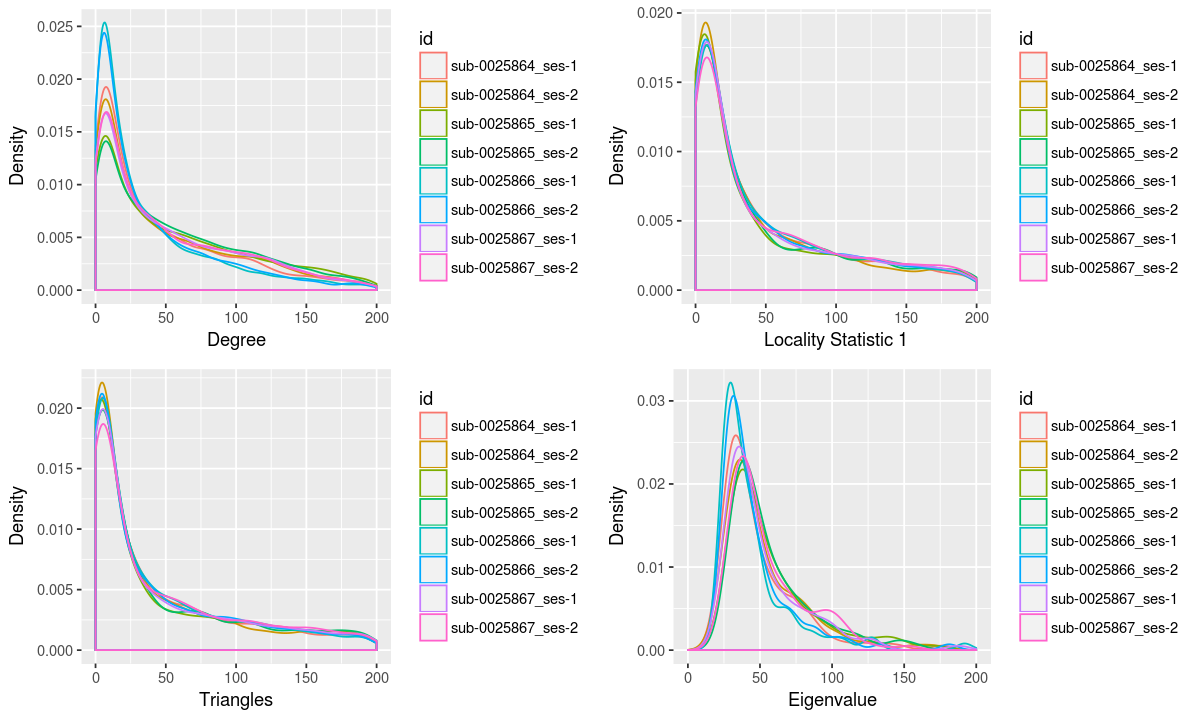

In [85]:
options(repr.plot.height=6, repr.plot.width=10)
degs <- ggplot(data = fx.degs.dat, aes(degs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Degree') +
    ylab('Density')

tris <- ggplot(data = fx.tris.dat, aes(tris, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Triangles') +
    ylab('Density')

locs <- ggplot(data = fx.locs.dat, aes(locs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Locality Statistic 1') +
    ylab('Density')

eigs <- ggplot(data = fx.eigs.dat, aes(eigs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Eigenvalue') +
    ylab('Density')

install.packages('Rmisc')

require(Rmisc)
multiplot(degs, tris, locs, eigs, cols=2)

# Igraph Results

And then the results using igraph for graph analysis:

Warning message:
"Removed 2482 rows containing non-finite values (stat_density)."Warning message:
"Removed 44127 rows containing non-finite values (stat_density)."Warning message:
"Removed 45180 rows containing non-finite values (stat_density)."Warning message:
"Removed 1 rows containing non-finite values (stat_density)."

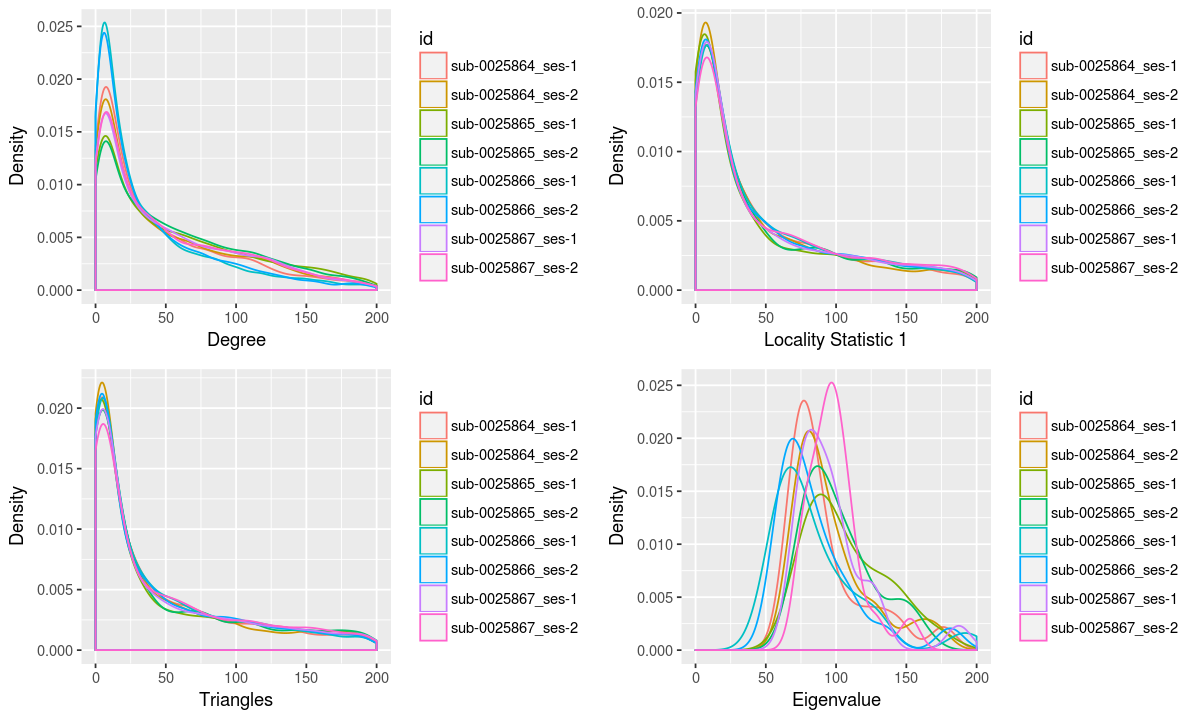

In [86]:
options(repr.plot.height=6, repr.plot.width=10)
degs <- ggplot(data = ig.degs.dat, aes(degs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Degree') +
    ylab('Density')

tris <- ggplot(data = ig.tris.dat, aes(tris, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Triangles') +
    ylab('Density')

locs <- ggplot(data = ig.locs.dat, aes(locs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Locality Statistic 1') +
    ylab('Density')

eigs <- ggplot(data = ig.eigs.dat, aes(eigs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Eigenvalue') +
    ylab('Density')

multiplot(degs, tris, locs, eigs, cols=2)

# Performance Comparison

Finally, we compare runtime (in seconds) and peak memory usage (in GB) for FlashGraphR vs igraph for the statistics computed above:

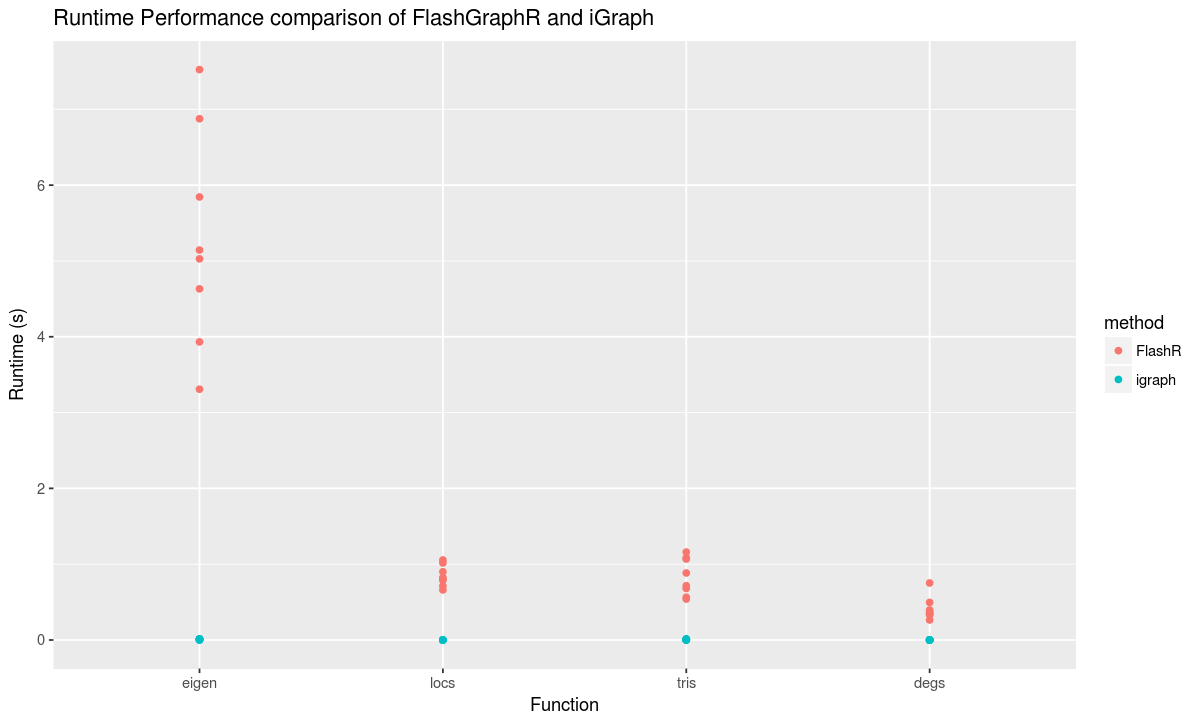

In [133]:
runtime <- data.frame(method="FlashR", func = "eigen", time = unlist(fx.eigs.time))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "locs", time = unlist(fx.locs.time)))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "tris", time = unlist(fx.tris.time)))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "degs", time = unlist(fx.degs.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "eigen", time = unlist(ig.eigs.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "locs", time = unlist(ig.locs.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "tris", time = unlist(ig.tris.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "degs", time = unlist(ig.degs.time)))

ggplot(runtime, aes(x=func, y=time, colour=method)) +
    geom_point() +
    xlab('Function') +
    ylab('Runtime (s)') +
    ggtitle('Runtime Performance comparison of FlashGraphR and iGraph')